# On-line Inference for Multiple Change Points Problems

**Work by Fearnhead and Liu**

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Block dataset

$$
    f(t) = \sum_{j} h_j K(t - t_j); \ K(t) = \{1 + \text{sgn}(t)\} / 2
$$

In [3]:
def K(t):
    return (1 + jnp.sign(t)) / 2

def f(t, t_elements, h_elements):
    res = h_elements * K(t - t_elements)
    return res.sum()

In [4]:
t_elements = jnp.array([10, 13, 15, 23, 25, 40, 44, 65, 76, 78, 81]) / 100
h_elements = jnp.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])

f_block = partial(f, t_elements=t_elements, h_elements=h_elements)
f_block = jax.vmap(f_block)

In [5]:
t = jnp.linspace(0, 1, 1000)
y_block = f_block(t)

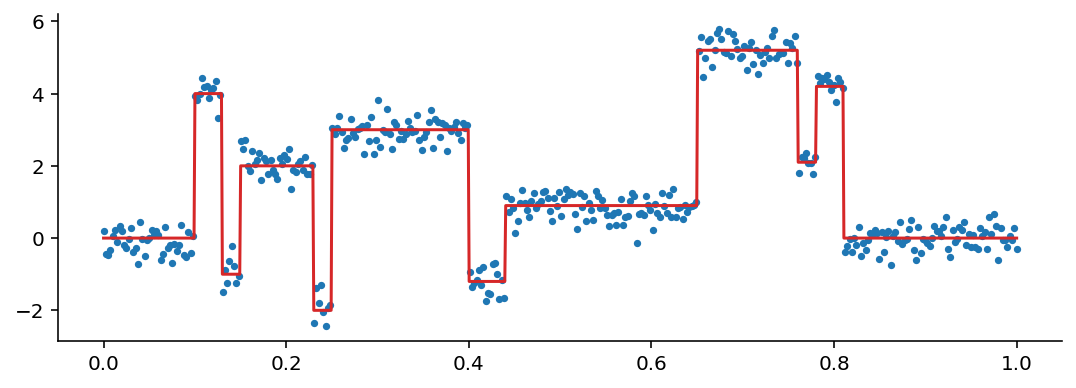

In [6]:
key = jax.random.PRNGKey(314)
n_obs = 400
t_obs = jnp.linspace(0, 1, n_obs)
y_obs = f_block(t_obs) + jax.random.normal(key, (n_obs,)) / 3

fig, ax = plt.subplots(figsize=(9, 3))
ax.scatter(t_obs, y_obs, s=7)
ax.plot(t, y_block, c="tab:red")

# Setup

In [69]:
def geom_rvs(key, size=()):
    rvs = jax.random.uniform(key, size)
    rvs = jnp.ceil(jnp.log(rvs) / jnp.log1p(-p))
    return rvs


def pmf_changepoint(t, p):
    """
    Probability mass function for the distance
    between two change points, as well as the probability
    mass function for the position of the first change point
    """
    return p * (1 - p) ** (t-1)


def cdf_changepoint(T, p):
    """
    Distribution function for the distance between
    two change points
    """
    timesteps = jnp.arange(T) + 1
    return pmf_changepoint(timesteps, p).sum()


def transition_probability(j, i, t, p):
    """
    Transition probablity of the time since the most recent
    changepoint prior to t+1:
                P(C_{t+1} = j | C_{t} = i)
    Note that
        1 = P(C_{t+1} = i | C_{t} = i) + P(C_{t+1} = t | C_{t} = i)
    """
    p1 = 1 - cdf_changepoint(t - i, p)
    p2 = cdf_changepoint(t - i, p) - cdf_changepoint(t - i - 1, p)
    p_transition = p1 * (j == i) + p2 * (j == t)
    p_transition = p_transition / (1 - cdf_changepoint(t - i - 1, p))
    return p_transition

In [78]:
p = 0.2

In [79]:
pmf_changepoint(5, p)

0.08192000000000002

In [80]:
cdf_changepoint(5, p)

DeviceArray(0.67232007, dtype=float32)

In [81]:
transition_probability(3, 1, 3, p)

DeviceArray(0.20000002, dtype=float32)

We note that

$$
    P(C_1=t) = g(1) = \text{Geom}(1 \vert p) = p
$$

In [84]:
key_init, key_steps = jax.random.split(key)

geom_rvs(key_init)

DeviceArray(2., dtype=float32)

In [89]:
pmf_changepoint(2, p)

0.16000000000000003

In [88]:
jax.scipy.stats.geom.pmf(2, p)

DeviceArray(0.16, dtype=float32)

In [101]:
cdf_changepoint(4, p)

DeviceArray(0.59040004, dtype=float32)

In [99]:
jax.scipy.stats.geom.pmf(jnp.arange(1, 5), p).sum()

DeviceArray(0.5904, dtype=float32)

$$
    p(C_2 = j \vert C_1 = i)
$$